<a href="https://colab.research.google.com/github/YairYarden/Deep-Learning/blob/sub-feature%2FQ3_VAE/Q3_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

VAE model is based on [This](https://github.com/lyeoni/pytorch-mnist-VAE/blob/master/pytorch-mnist-VAE.ipynb) github code


# Imports

In [57]:
import numpy as np
from datetime import datetime 
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter

import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

from sklearn.svm import SVC # For SVM

%load_ext tensorboard

# check if CUDA is available
is_gpu_available = torch.cuda.is_available()

if not is_gpu_available:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

DIR_PATH = '/content/drive/MyDrive/Deep_learning_05107255/ex3_316168061_313471526'


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
CUDA is not available.  Training on CPU ...


# Mount Google Drive

In [58]:
from google.colab import drive
drive.mount('/content/drive/')

drive_path = '/content/drive/MyDrive/Deep_learning_05107255/ex3_316168061_313471526'

# Path for check point
ckpts_path = os.path.join(drive_path, 'Q3_VAE', 'checkpoints')
os.makedirs(ckpts_path, exist_ok=True)

print('Drive Path : ' + drive_path)
print('Check points Path : ' + ckpts_path)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Drive Path : /content/drive/MyDrive/Deep_learning_05107255/ex3_316168061_313471526
Check points Path : /content/drive/MyDrive/Deep_learning_05107255/ex3_316168061_313471526/Q3_VAE/checkpoints


# Functions for data loading

In [59]:
def get_train_samplers(labels, num_labels:int):
    """
    Synopsis : 
        returns 2 samplers of the train data, one for the labeled data and one for the unlabeled data.

    Args:
        labels : array of all the labels in the dataset.
        num_labels : number of labeled elements
    """

    num_classes = int(np.max(labels) + 1)
    num_labels_per_class = num_labels // num_classes

    labeled_indices = []
    unlabeled_indices = []

    for i_class in range(num_classes):
        curr_label_indices = np.where(labels==i_class)[0]
        labeled_indices.extend(curr_label_indices[:num_labels_per_class].tolist())
        unlabeled_indices.extend(curr_label_indices[num_labels_per_class:].tolist())

    return SubsetRandomSampler(labeled_indices), SubsetRandomSampler(unlabeled_indices)


def get_dataloaders(num_labels, batch_size, num_workers=2):
  
    labeled_sampler, unlabeled_sampler = get_train_samplers(train_labels, num_labels)
    train_labeled = DataLoader(train_dataset,
                               batch_size=batch_size,
                               sampler=labeled_sampler,
                               num_workers=num_workers)
    

    train_unlabeled = DataLoader(train_dataset,
                                 batch_size=batch_size,
                                 sampler=unlabeled_sampler,
                                 num_workers=num_workers)
    
    test = DataLoader(test_dataset,
                      batch_size=batch_size,
                      num_workers=num_workers)
    
    return train_labeled, train_unlabeled, test

# Load Data

In [60]:
# Define transform
transform = transforms.Compose([transforms.ToTensor()])

# Load Dataset
train_dataset = datasets.FashionMNIST(root=os.path.join(drive_path), 
                               train=True, 
                               transform=transform,
                               download=True)

train_labels = np.array([label for _, label in train_dataset])

test_dataset = datasets.FashionMNIST(root=os.path.join(drive_path), 
                               train=False, 
                               transform=transform)


# Visualize a batch of training data


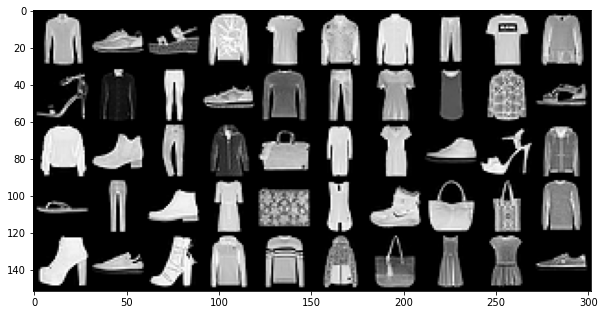

In [61]:
train_labeled, _, _ = get_dataloaders(num_labels=50, batch_size=50)
dataiter = iter(train_labeled)
images, labels = dataiter.next()

plt.figure(figsize=(10,10))
grid = torchvision.utils.make_grid(tensor=images, nrow=10)
grid = np.clip(grid,0,1)
plt.imshow(X=np.transpose(grid, axes=(1,2,0)), cmap="gray");

# Define VAE Model

In [62]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))

        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return torch.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# Functions for Training

## Loss Function

In [63]:
def vae_loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD


## Plotting

In [64]:
def plot_vae_samples(model, num_samples=3):
    fig, axs = plt.subplots(1, num_samples, figsize=[10,5])
    with torch.no_grad():
        z = torch.randn(num_samples, 50, device=DEVICE)
        sample = model.decoder(z).cpu()
    
    for i, ax in enumerate(axs):
        ax.imshow(sample[i].view([28,28]), cmap='gray')
        ax.axis('off')

    plt.tight_layout()

    plt.show()

## Train Epoch Function

In [65]:
def train_vae_epoch(vae_model, train_loader, optimizer, epoch_idx, print_every_epoch = 100):
    vae_model.train()
    train_loss = 0
    num_samples = 0

    for batch_idx, (data, _) in enumerate(train_loader):

        data = data.to(DEVICE)
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae_model(data)
        loss = vae_loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        num_samples += data.shape[0]
        optimizer.step()
        
        if batch_idx % print_every_epoch == 0:
            print('Train Epoch: {} [batch: {}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch_idx, batch_idx, len(train_loader),
                print_every_epoch * batch_idx / len(train_loader), loss.item() / len(data)))
            
    avg_loss = train_loss / num_samples
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch_idx, avg_loss))

    return avg_loss

## Full training function

In [66]:
def train_vae_full(vae_model, optimizer, train_loader, test_loader, epochs, max_epochs_unimproved=3):

    min_loss = np.inf
    counter_epochs_unimproved = 0
    for epoch in range(1, epochs+1):
        curr_loss = train_vae_epoch(vae_model=vae_model,
                                    train_loader=train_loader, 
                                    optimizer=optimizer,
                                    epoch_idx=epoch)
        
        plot_vae_samples(vae_model, num_samples = 5)
        
        if curr_loss <  min_loss:
            min_loss = curr_loss
            counter_epochs_unimproved = 0

        else:
            print('updating counter_epochs_unimproved')
            counter_epochs_unimproved += 1
      
        if counter_epochs_unimproved == max_epochs_unimproved:
            print(f'loss has not imporoved for {max_epochs_unimproved} epochs. stoping training.')

    return vae_model


## Test

In [67]:
def test_vae(vae_model, test_loader):
    vae_model.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(DEVICE)
            recon, mu, log_var = vae_model(data)
            
            # sum up batch loss
            test_loss += vae_loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

    return test_loss.item()

# Define SVM Model

## Encode 

In [68]:
def encode_data(data_loader, vae_model):
    """
    Synopsis : 
        encode data in data_loader to prepare for svm training
    """
    vae_model.eval()
    vae_model.to(DEVICE)

    mu_vec = []
    labels = []

    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(DEVICE)
            mu, _ = vae_model.encoder(x.view(-1, 784)) # 784 = 28*28
            mu_vec.append(mu)
            labels.extend(y.tolist())

        encoded_data = torch.cat(mu_vec)

    return encoded_data.cpu().numpy(), np.asarray(labels)

## Train SVM

In [69]:
def train_svm(train_loader, vae_model):
    encoded_data, labels = encode_data(train_loader, vae_model)
    
    svm = SVC()
    svm.fit(encoded_data, labels)

    return svm

## Compute Classification Error

In [70]:
def compute_classification_error(svm_model, vae_model, test_loader):
    encoded_data, labels = encode_data(test_loader, vae_model)
    acc_score = svm_model.score(encoded_data, labels)

    return (1 - acc_score) * 100

# M1 Scheme

In [71]:
def train_m1_scheme(vae_model,
                    optimizer,
                    num_labels:int, 
                    batch_size=128,
                    num_epochs=10):
    """
    Synopsis : 
        implement the M1 scheme from the paper. 

    outputs : 
        error, vae, svm
    """
    train_labeled_loader, train_unlabeled_loader, test_loader = get_dataloaders(num_labels=num_labels,
                                                                                batch_size=batch_size)

    print('Training the VAE...')
    vae_model = train_vae_full(vae_model, optimizer, train_unlabeled_loader, test_loader, num_epochs)

    print('Training the SVM...')
    svm_model = train_svm(train_labeled_loader, vae_model)

    print('Conmputing error')
    error = compute_classification_error(svm_model, vae_model, test_loader)
    
    return error, vae_model, svm_model


# Functions for Save & Load Model

In [72]:
import pickle

def save_models(vae_model, svm_model, name):
    vae_path = os.path.join(ckpts_path, f'{name}_vae.ckpt')
    svm_path = os.path.join(ckpts_path, f'{name}_svm.pkl')

    torch.save({'model_state_dict': vae_model.state_dict()}, vae_path)

    with open(svm_path, 'wb') as f:
        pickle.dump(svm_model, f)

def load_models(name):
    """
    returns vae and svm
    """
    vae_path = os.path.join(ckpts_path, f'{name}_vae.ckpt')
    svm_path = os.path.join(ckpts_path, f'{name}_svm.pkl')

    checkpoint = torch.load(vae_path)
    vae_model = VAE(x_dim=784, h_dim1= 600, h_dim2=600, z_dim=50)
    vae_model.load_state_dict(checkpoint['model_state_dict'])

    with open(svm_path, 'rb') as f:
        svm_model = pickle.load(f)

    return vae_model, svm_model

# Train The Network

---------- num_labels=100 ----------
Training the VAE...
Train Epoch: 1 [batch: 0/468 (0%)]	Loss: 544.732727
Train Epoch: 1 [batch: 100/468 (21%)]	Loss: 303.315643
Train Epoch: 1 [batch: 200/468 (43%)]	Loss: 283.542511
Train Epoch: 1 [batch: 300/468 (64%)]	Loss: 266.226257
Train Epoch: 1 [batch: 400/468 (85%)]	Loss: 274.801483
====> Epoch: 1 Average loss: 289.0043


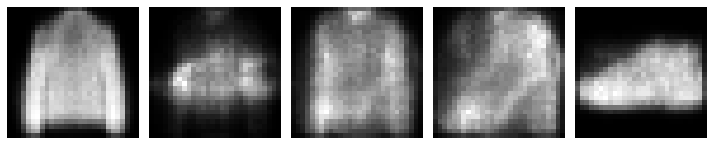

Train Epoch: 2 [batch: 0/468 (0%)]	Loss: 245.357437
Train Epoch: 2 [batch: 100/468 (21%)]	Loss: 252.233826
Train Epoch: 2 [batch: 200/468 (43%)]	Loss: 251.996506
Train Epoch: 2 [batch: 300/468 (64%)]	Loss: 258.536926
Train Epoch: 2 [batch: 400/468 (85%)]	Loss: 261.426788
====> Epoch: 2 Average loss: 254.5292


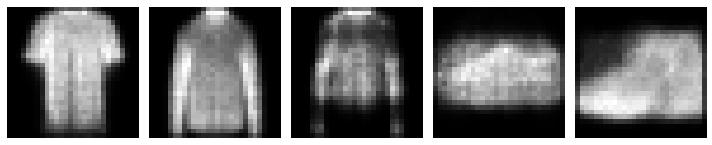

Train Epoch: 3 [batch: 0/468 (0%)]	Loss: 253.508987
Train Epoch: 3 [batch: 100/468 (21%)]	Loss: 246.164749
Train Epoch: 3 [batch: 200/468 (43%)]	Loss: 251.833878
Train Epoch: 3 [batch: 300/468 (64%)]	Loss: 258.251984
Train Epoch: 3 [batch: 400/468 (85%)]	Loss: 247.985138
====> Epoch: 3 Average loss: 249.1254


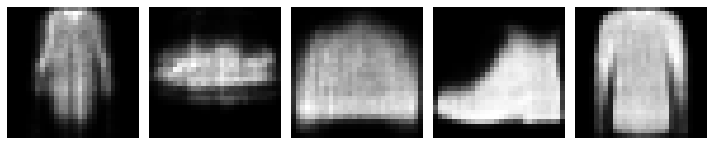

Train Epoch: 4 [batch: 0/468 (0%)]	Loss: 254.026199
Train Epoch: 4 [batch: 100/468 (21%)]	Loss: 249.417740
Train Epoch: 4 [batch: 200/468 (43%)]	Loss: 250.225403
Train Epoch: 4 [batch: 300/468 (64%)]	Loss: 255.792847
Train Epoch: 4 [batch: 400/468 (85%)]	Loss: 243.634872
====> Epoch: 4 Average loss: 246.4467


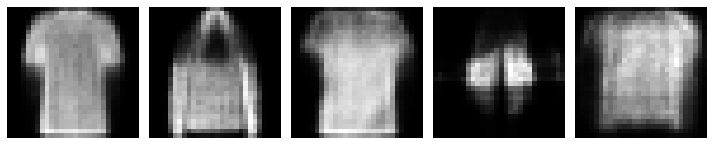

Train Epoch: 5 [batch: 0/468 (0%)]	Loss: 240.847382
Train Epoch: 5 [batch: 100/468 (21%)]	Loss: 233.182663
Train Epoch: 5 [batch: 200/468 (43%)]	Loss: 252.756256
Train Epoch: 5 [batch: 300/468 (64%)]	Loss: 235.688904
Train Epoch: 5 [batch: 400/468 (85%)]	Loss: 232.620102
====> Epoch: 5 Average loss: 244.6238


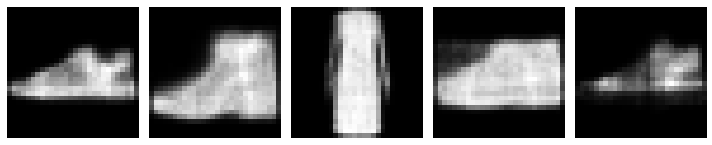

Training the SVM...
Conmputing error
---------- num_labels=600 ----------
Training the VAE...
Train Epoch: 1 [batch: 0/465 (0%)]	Loss: 237.300018
Train Epoch: 1 [batch: 100/465 (22%)]	Loss: 243.962997
Train Epoch: 1 [batch: 200/465 (43%)]	Loss: 241.253128
Train Epoch: 1 [batch: 300/465 (65%)]	Loss: 251.101959
Train Epoch: 1 [batch: 400/465 (86%)]	Loss: 243.244324
====> Epoch: 1 Average loss: 243.4091


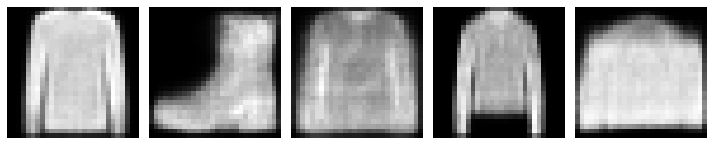

Train Epoch: 2 [batch: 0/465 (0%)]	Loss: 246.640961
Train Epoch: 2 [batch: 100/465 (22%)]	Loss: 244.949661
Train Epoch: 2 [batch: 200/465 (43%)]	Loss: 245.474030
Train Epoch: 2 [batch: 300/465 (65%)]	Loss: 248.463959
Train Epoch: 2 [batch: 400/465 (86%)]	Loss: 247.075378
====> Epoch: 2 Average loss: 242.4603


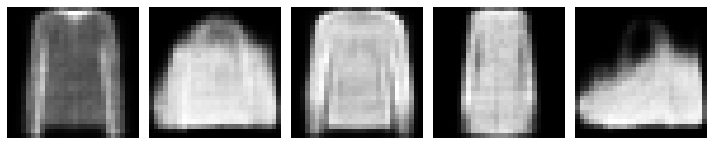

Train Epoch: 3 [batch: 0/465 (0%)]	Loss: 253.603363
Train Epoch: 3 [batch: 100/465 (22%)]	Loss: 234.963959
Train Epoch: 3 [batch: 200/465 (43%)]	Loss: 248.357468
Train Epoch: 3 [batch: 300/465 (65%)]	Loss: 242.483368
Train Epoch: 3 [batch: 400/465 (86%)]	Loss: 235.920975
====> Epoch: 3 Average loss: 241.8398


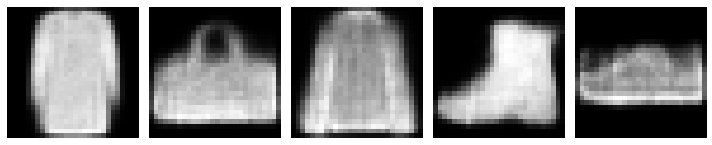

Train Epoch: 4 [batch: 0/465 (0%)]	Loss: 242.757324
Train Epoch: 4 [batch: 100/465 (22%)]	Loss: 231.793854
Train Epoch: 4 [batch: 200/465 (43%)]	Loss: 243.765396
Train Epoch: 4 [batch: 300/465 (65%)]	Loss: 242.764160
Train Epoch: 4 [batch: 400/465 (86%)]	Loss: 245.988678
====> Epoch: 4 Average loss: 241.2363


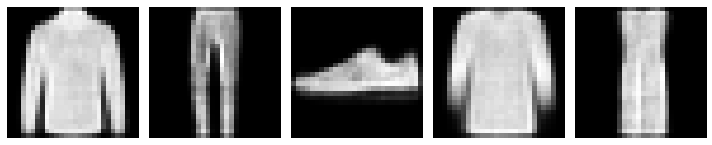

Train Epoch: 5 [batch: 0/465 (0%)]	Loss: 239.756332
Train Epoch: 5 [batch: 100/465 (22%)]	Loss: 231.917480
Train Epoch: 5 [batch: 200/465 (43%)]	Loss: 254.459351
Train Epoch: 5 [batch: 300/465 (65%)]	Loss: 246.914459
Train Epoch: 5 [batch: 400/465 (86%)]	Loss: 228.412323
====> Epoch: 5 Average loss: 240.7691


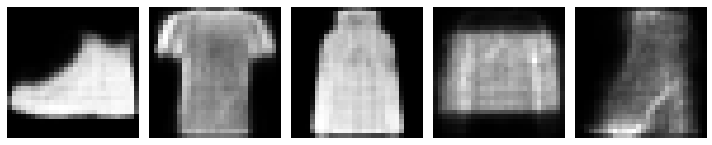

Training the SVM...
Conmputing error
---------- num_labels=1000 ----------
Training the VAE...
Train Epoch: 1 [batch: 0/461 (0%)]	Loss: 232.484375
Train Epoch: 1 [batch: 100/461 (22%)]	Loss: 233.499146
Train Epoch: 1 [batch: 200/461 (43%)]	Loss: 243.125183
Train Epoch: 1 [batch: 300/461 (65%)]	Loss: 247.861420
Train Epoch: 1 [batch: 400/461 (87%)]	Loss: 232.343964
====> Epoch: 1 Average loss: 240.4991


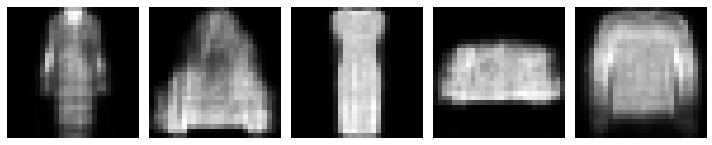

Train Epoch: 2 [batch: 0/461 (0%)]	Loss: 229.044449
Train Epoch: 2 [batch: 100/461 (22%)]	Loss: 246.069000
Train Epoch: 2 [batch: 200/461 (43%)]	Loss: 237.764481
Train Epoch: 2 [batch: 300/461 (65%)]	Loss: 240.406860
Train Epoch: 2 [batch: 400/461 (87%)]	Loss: 247.158173
====> Epoch: 2 Average loss: 240.0855


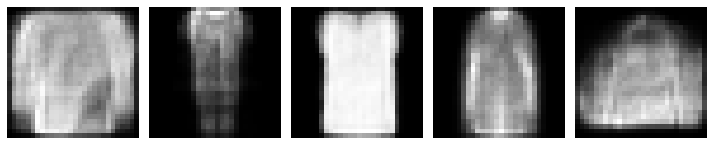

Train Epoch: 3 [batch: 0/461 (0%)]	Loss: 243.796539
Train Epoch: 3 [batch: 100/461 (22%)]	Loss: 228.101639
Train Epoch: 3 [batch: 200/461 (43%)]	Loss: 234.439255
Train Epoch: 3 [batch: 300/461 (65%)]	Loss: 238.831497
Train Epoch: 3 [batch: 400/461 (87%)]	Loss: 245.583252
====> Epoch: 3 Average loss: 239.7711


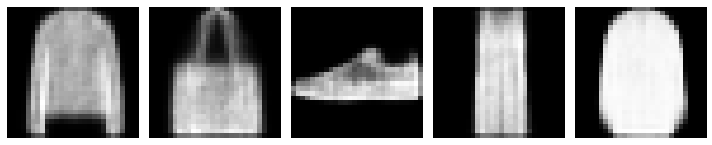

Train Epoch: 4 [batch: 0/461 (0%)]	Loss: 245.266998
Train Epoch: 4 [batch: 100/461 (22%)]	Loss: 238.635712
Train Epoch: 4 [batch: 200/461 (43%)]	Loss: 238.077744
Train Epoch: 4 [batch: 300/461 (65%)]	Loss: 222.131088
Train Epoch: 4 [batch: 400/461 (87%)]	Loss: 251.602707
====> Epoch: 4 Average loss: 239.5217


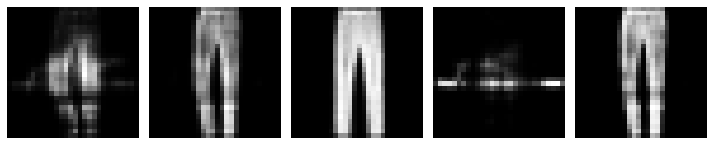

Train Epoch: 5 [batch: 0/461 (0%)]	Loss: 227.936829
Train Epoch: 5 [batch: 100/461 (22%)]	Loss: 236.015381
Train Epoch: 5 [batch: 200/461 (43%)]	Loss: 233.777313
Train Epoch: 5 [batch: 300/461 (65%)]	Loss: 241.449066
Train Epoch: 5 [batch: 400/461 (87%)]	Loss: 248.155853
====> Epoch: 5 Average loss: 239.2814


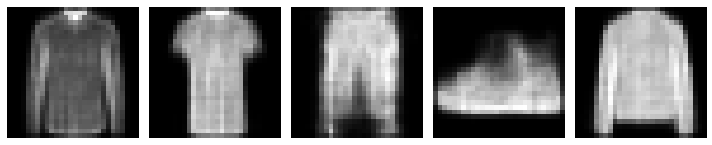

Training the SVM...
Conmputing error
---------- num_labels=3000 ----------
Training the VAE...
Train Epoch: 1 [batch: 0/446 (0%)]	Loss: 226.105133
Train Epoch: 1 [batch: 100/446 (22%)]	Loss: 238.447266
Train Epoch: 1 [batch: 200/446 (45%)]	Loss: 243.764969
Train Epoch: 1 [batch: 300/446 (67%)]	Loss: 241.633377
Train Epoch: 1 [batch: 400/446 (90%)]	Loss: 239.719650
====> Epoch: 1 Average loss: 239.1239


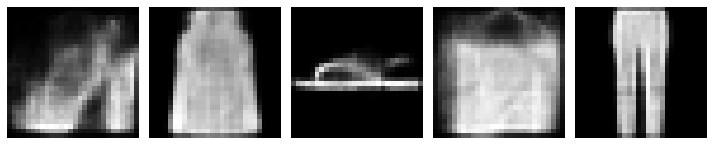

Train Epoch: 2 [batch: 0/446 (0%)]	Loss: 258.784912
Train Epoch: 2 [batch: 100/446 (22%)]	Loss: 237.715012
Train Epoch: 2 [batch: 200/446 (45%)]	Loss: 232.895630
Train Epoch: 2 [batch: 300/446 (67%)]	Loss: 242.790878
Train Epoch: 2 [batch: 400/446 (90%)]	Loss: 239.658340
====> Epoch: 2 Average loss: 238.8117


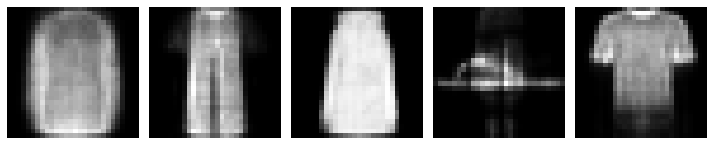

Train Epoch: 3 [batch: 0/446 (0%)]	Loss: 236.544922
Train Epoch: 3 [batch: 100/446 (22%)]	Loss: 236.107651
Train Epoch: 3 [batch: 200/446 (45%)]	Loss: 230.928864
Train Epoch: 3 [batch: 300/446 (67%)]	Loss: 235.987717
Train Epoch: 3 [batch: 400/446 (90%)]	Loss: 235.056168
====> Epoch: 3 Average loss: 238.6978


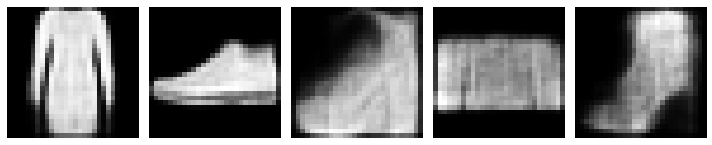

Train Epoch: 4 [batch: 0/446 (0%)]	Loss: 263.508362
Train Epoch: 4 [batch: 100/446 (22%)]	Loss: 234.480911
Train Epoch: 4 [batch: 200/446 (45%)]	Loss: 232.040466
Train Epoch: 4 [batch: 300/446 (67%)]	Loss: 245.660629
Train Epoch: 4 [batch: 400/446 (90%)]	Loss: 235.699326
====> Epoch: 4 Average loss: 238.4946


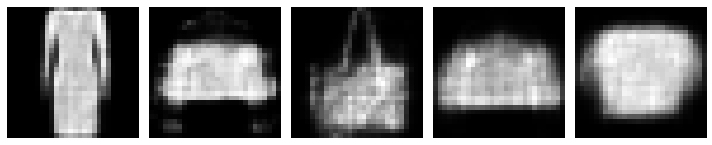

Train Epoch: 5 [batch: 0/446 (0%)]	Loss: 231.132385
Train Epoch: 5 [batch: 100/446 (22%)]	Loss: 242.231094
Train Epoch: 5 [batch: 200/446 (45%)]	Loss: 235.092072
Train Epoch: 5 [batch: 300/446 (67%)]	Loss: 233.947403
Train Epoch: 5 [batch: 400/446 (90%)]	Loss: 228.831665
====> Epoch: 5 Average loss: 238.3545


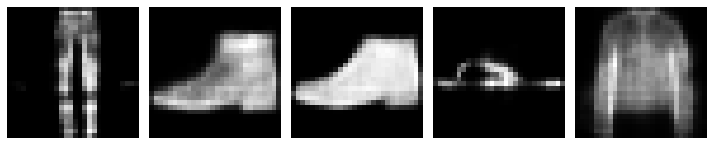

Training the SVM...
Conmputing error


In [73]:
vae_model = VAE(x_dim=784, h_dim1= 600, h_dim2=600, z_dim=50).to(DEVICE)
optimizer = torch.optim.Adam(vae_model.parameters(), lr=1e-3)

results = {}
for num_labels in [100, 600, 1000, 3000]:
    print('-'*10, f'num_labels={num_labels}', '-'*10)
    curr_error, curr_vae, curr_svm = train_m1_scheme(vae_model, optimizer, num_labels,
                                                     batch_size=128, num_epochs=5)
    results[num_labels] = curr_error, curr_vae, curr_svm

# Show Results

In [74]:
for num_labels, (error, vae, svm) in results.items():
    print('-'*30)
    print(f'| {num_labels} | {error}')

------------------------------
| 100 | 34.209999999999994
------------------------------
| 600 | 23.799999999999997
------------------------------
| 1000 | 22.119999999999994
------------------------------
| 3000 | 19.44
